# Customer Cliff Dive in Yammer

This is a 4-hour data challenge provided by Insight, 19B NYC

Yammer is a social network for communicating with coworkers. Individuals can **share documents**,  **updates**, and **ideas** by **posting them in groups**. It is free to use but companies pay license fees to access administrative controls, including integration with **user management systems** like **ActiveDirectory**.

My job: Analytics team in Engineering Org.

Problem: There is a drop in user engagement what do you recommend to the Eng. Org.?

The Data come from four tables:
**Users**, **Events**, **Email Events**, and **Rollup Periods**

- Users ::         Unique user ID and descriptive info about the user’s account
- Events ::         Each row is an event, or single action, by user (user ID)
- Email Events :: Similar to events but just related to the sending of emails
- Rollup Periods :: Less necessary, used to create rolling time periods


<img src="dive2.png">

## The Task / Goal

The goal of this project is to identify actionable insight into what has **caused** the decrease in user engagement and provide recommendations to the organization (engineering?).

### Import Libraries

In [495]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
#plt.rcParams.update({'font.size': 18})
sns.set_style("darkgrid")
import pandas_profiling as pp
import numpy as np
import datetime
from catboost import Pool, CatBoostClassifier, cv

### Load Data Tables

In [527]:
users = pd.read_csv('yammer_users.csv')
events1 = pd.read_csv('yammer_events_1.csv', index_col=0)
events2 = pd.read_csv('yammer_events_2.csv', index_col=0)
events = events1.append(events2)
emails = pd.read_csv('yammer_emails.csv')

Quick look at head

In [528]:
users.head(2)
events.head(2)
emails.head(2)

user_id           created_at  company_id language         activated_at  \
0      0.0  2013-01-01 20:59:39      5737.0  english  2013-01-01 21:01:07   
1      1.0  2013-01-01 13:07:46        28.0  english                  NaN   

     state  
0   active  
1  pending

user_id          occurred_at  event_type event_name location  \
0  10522.0  2014-05-02 11:02:39  engagement      login    Japan   
1  10522.0  2014-05-02 11:02:53  engagement  home_page    Japan   

                   device  user_type  
0  dell inspiron notebook        3.0  
1  dell inspiron notebook        3.0

user_id          occurred_at              action  user_type
0      0.0  2014-05-06 09:30:00  sent_weekly_digest        1.0
1      0.0  2014-05-13 09:30:00  sent_weekly_digest        1.0

In [531]:
events['occurred_at'].min()
events['occurred_at'].max()

'2014-05-01 00:54:09'

'2014-08-31 23:03:39'

### Initial EDA for users table

In [36]:
users.head(3)

user_id           created_at  company_id language         activated_at  \
0      0.0  2013-01-01 20:59:39      5737.0  english  2013-01-01 21:01:07   
1      1.0  2013-01-01 13:07:46        28.0  english                  NaN   
2      2.0  2013-01-01 10:59:05        51.0  english                  NaN   

     state  
0   active  
1  pending  
2  pending

### Make plots 

<Figure size 1152x576 with 0 Axes>

Text(0.5, 1.0, 'Activation Time')

Text(0.5, 0, 'Creation Date')

Text(0, 0.5, 'Seconds to activation')

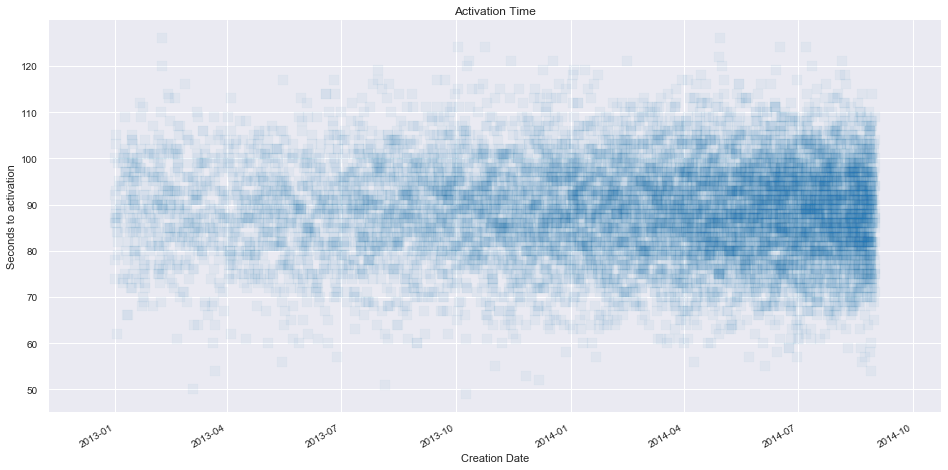

In [539]:
# Activation time vs time
created_at = pd.to_datetime(users['created_at'][users[users['activated_at'].notnull()].index])
time = [] 
for f in users['activation_time'][users[users['activated_at'].notnull()].index]:
    time.append(f.total_seconds())
    
plt.figure(figsize=(16,8))
plt.scatter(created_at,time,s=100, marker='s', alpha=0.05)
plt.title('Activation Time')
plt.xlabel('Creation Date')
plt.ylabel('Seconds to activation')
plt.gcf().autofmt_xdate()
#plt.show()
plt.savefig('activation_time_vs_time.png')

Difficult to determine a trend in the data. Could be improved by binning and averaging.

Take home: no evident increase in activation time in / after August.

#### Average percent to activate by month

Now let's make each consecutive month an int and plot that vs the percent of users created during that month to activate.

In [210]:
users.head()

user_id           created_at  company_id language         activated_at  \
0      0.0  2013-01-01 20:59:39      5737.0  english  2013-01-01 21:01:07   
1      1.0  2013-01-01 13:07:46        28.0  english                  NaN   
2      2.0  2013-01-01 10:59:05        51.0  english                  NaN   
3      3.0  2013-01-01 18:40:36      2800.0   german  2013-01-01 18:42:02   
4      4.0  2013-01-01 14:37:51      5110.0   indian  2013-01-01 14:39:05   

     state  activated  activation_time            creation  
0   active       True  0 days 00:01:28 2013-01-01 20:59:39  
1  pending      False              NaN 2013-01-01 13:07:46  
2  pending      False              NaN 2013-01-01 10:59:05  
3   active       True  0 days 00:01:26 2013-01-01 18:40:36  
4   active       True  0 days 00:01:14 2013-01-01 14:37:51

Find the percent of new users that activated for each month and save to dictionary

In [378]:
results = {}
created = {}
years = [2013,2014]
months = [1,2,3,4,5,6,7,8,9,10,11,12]

for j in years:
    for i in months:
        if i < 12:
            end_time = datetime.datetime(j,i+1,1,0)
            start_time = datetime.datetime(j,i,1,0)
            n_tot = len(users[(users['creation'] > start_time) & (users['creation'] < end_time)])
            n_act = len(users[(users['creation'] > start_time) & (users['creation'] < end_time) & (users['activated'] == True)])
            if n_tot > 0:
                perc_act = n_act / n_tot
                results[start_time] = perc_act
        else:
            end_time = datetime.datetime(j,12,31,0)
            start_time = datetime.datetime(j,i,1,0)
            n_tot = len(users[(users['creation'] > start_time) & (users['creation'] < end_time)])
            n_act = len(users[(users['creation'] > start_time) & (users['creation'] < end_time) & (users['activated'] == True)])
            if n_tot > 0:
                perc_act = n_act / n_tot
                results[start_time] = perc_act
for j in years:
    for i in months:
        if i < 12:
            end_time = datetime.datetime(j,i+1,1,0)
            start_time = datetime.datetime(j,i,1,0)
            n_cre = 0
            n_cre = len(users[(users['creation'] > start_time) & (users['creation'] < end_time)])
            created[start_time] = n_cre
        else:
            end_time = datetime.datetime(j,12,31,0)
            start_time = datetime.datetime(j,i,1,0)
            n_cre = 0
            n_cre = len(users[(users['creation'] > start_time) & (users['creation'] < end_time)])
            created[start_time] = n_cre    
            
            

#### Scatter plot of new users per month


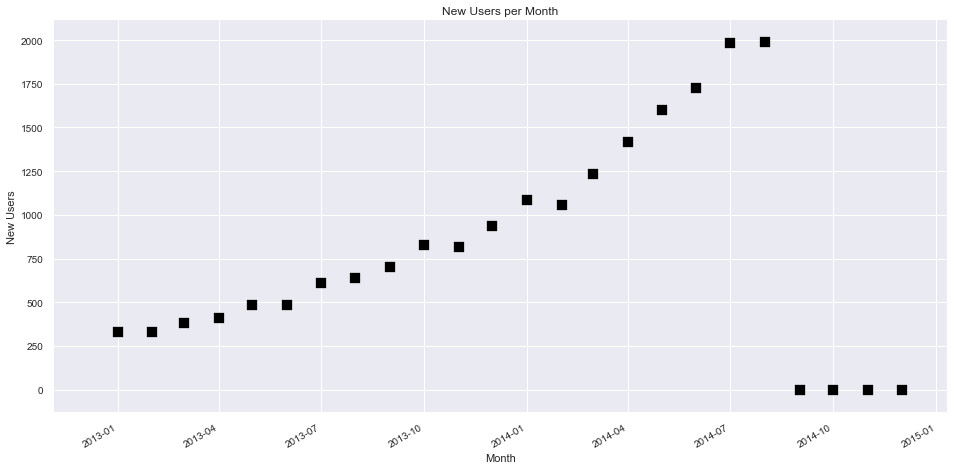

In [384]:
scatter_plot(created,'New Users per Month','Month','New Users')

This is the key piece of the puzzle. **The data doesn't go past Aug '14**

Plot the results

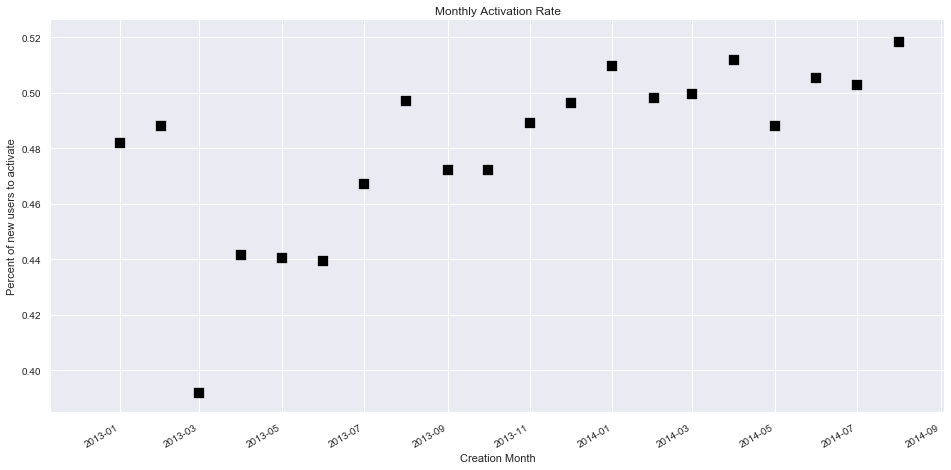

In [485]:
scatter_plot(results, 'Monthly Activation Rate','Creation Month', 'Percent of new users to activate')

This data actually ends at the turning point, no activation means no new users..

## Events Table EDA

In [319]:
events.head()

user_id          occurred_at  event_type    event_name location  \
0  10522.0  2014-05-02 11:02:39  engagement         login    Japan   
1  10522.0  2014-05-02 11:02:53  engagement     home_page    Japan   
2  10522.0  2014-05-02 11:03:28  engagement  like_message    Japan   
3  10522.0  2014-05-02 11:04:09  engagement    view_inbox    Japan   
4  10522.0  2014-05-02 11:03:16  engagement    search_run    Japan   

                   device  user_type          occurrence  
0  dell inspiron notebook        3.0 2014-05-02 11:02:39  
1  dell inspiron notebook        3.0 2014-05-02 11:02:53  
2  dell inspiron notebook        3.0 2014-05-02 11:03:28  
3  dell inspiron notebook        3.0 2014-05-02 11:04:09  
4  dell inspiron notebook        3.0 2014-05-02 11:03:16

#### Monthly users created

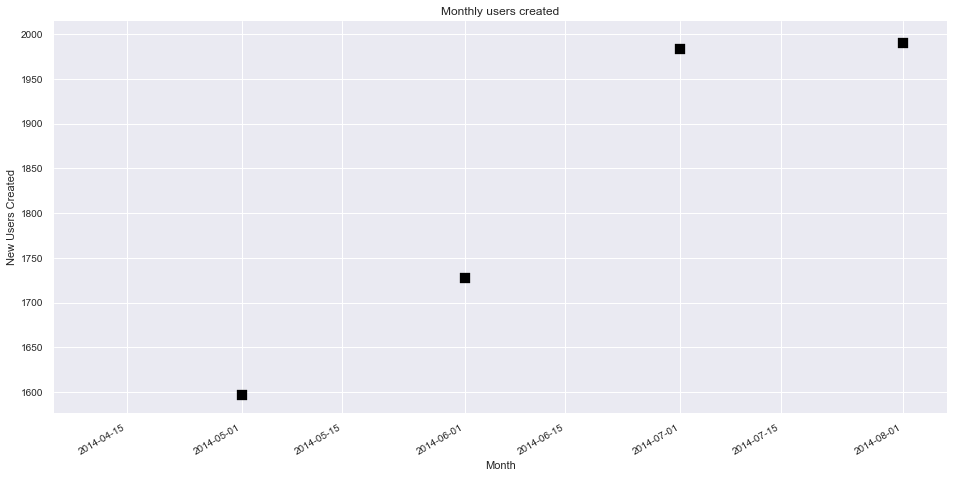

In [371]:
scatter_plot(sign_ups,'Monthly users created','Month','New Users Created')
events['occurrence'].min()
events['occurrence'].max()

A key take away here is that this data is very limited. First, the oldest information only dates back to June 2015 and the youngest data doesn't even go into August (the problematic month). However, if we check the min and max occurrence date in the table, there is data younger. Meaning that **there are no new users created in or after August**. 

#### Average number of engagements per months

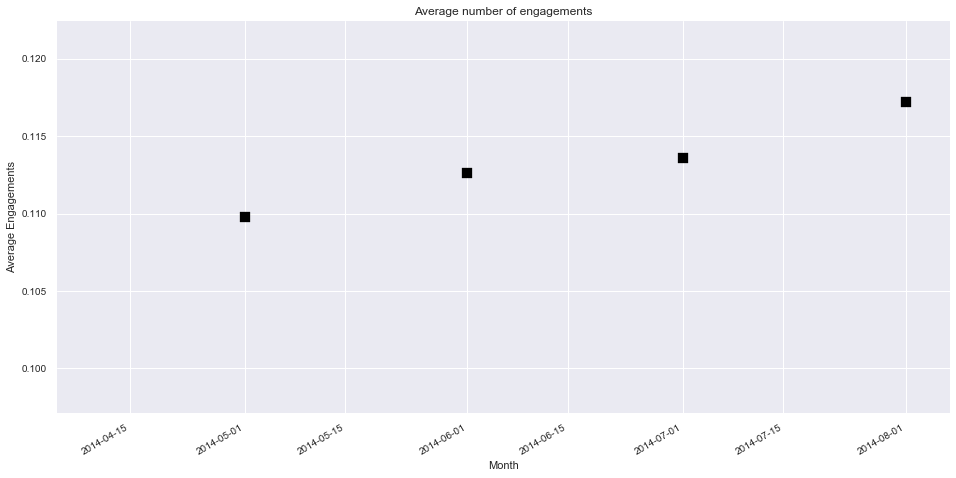

In [375]:
scatter_plot(results,'Average number of engagements','Month','Average Engagements')

In [ ]:
years = [2013,2014]
months = [1,2,3,4,5,6,7,8,9,10,11,12]

results = {}

for j in years:
    for i in months:
        if i < 12:
            end_time = datetime.datetime(j,i+1,1,0)
            start_time = datetime.datetime(j,i,1,0)
            n_tot = len(events[(events['occurrence'] > start_time) & (events['occurrence'] < end_time)])
            n_sign = len(events[(events['occurrence'] > start_time) & (events['occurrence'] < end_time) & (events['event_name'] == 'login')])
            if n_tot > 0:
                perc_act = n_sign / n_tot
                results[start_time] = perc_act
        else:
            end_time = datetime.datetime(j,12,31,0)
            start_time = datetime.datetime(j,i,1,0)
            n_tot = len(events[(events['occurrence'] > start_time) & (events['occurrence'] < end_time)])
            n_sign = len(events[(events['occurrence'] > start_time) & (events['occurrence'] < end_time) & (events['event_name'] == 'login')])
            if n_tot > 0:
                perc_act = n_sign / n_tot
                results[start_time] = perc_act

sign_ups = {}

for j in years:
    for i in months:
        if i < 12:
            end_time = datetime.datetime(j,i+1,1,0)
            start_time = datetime.datetime(j,i,1,0)
            n_tot = len(events[(events['occurrence'] > start_time) & (events['occurrence'] < end_time)])
            n_sign = len(events[(events['occurrence'] > start_time) & (events['occurrence'] < end_time) & (events['event_name'] == 'create_user')])
            if n_tot > 0:
                perc_act = n_sign / n_tot
                sign_ups[start_time] = n_sign
        else:
            end_time = datetime.datetime(j,12,31,0)
            start_time = datetime.datetime(j,i,1,0)
            n_tot = len(events[(events['occurrence'] > start_time) & (events['occurrence'] < end_time)])
            n_sign = len(events[(events['occurrence'] > start_time) & (events['occurrence'] < end_time) & (events['event_name'] == 'create_user')])
            if n_tot > 0:
                perc_act = n_sign / n_tot
                sign_ups[start_time] = n_sign
                        


In [ ]:
def scatter_plot(item,str1,str2,str3):
    plt.figure(figsize=(16,8))
    for j in item.keys():
        plt.scatter(j,item[j],s=100, marker='s', color='k')
    plt.title(str1)
    plt.xlabel(str2)
    plt.ylabel(str3)    
    plt.gcf().autofmt_xdate()
    plt.show()

# Modeling and Classification

### Random Forest Classifier

**What else has changed before and after the turning point?**

For this problem, we have categorical data that we can quickly one hot encode, so we will employ **RFClassifier** to
train on a subset of the data. Essentially, this will create a model that identify key features different between 
the before the spike and after the spike. 


Once trained, we can look at feature importance to point us toward what is happening. Ideally, this feature would provide some evidence of the change (i.e., did a subclass of the feature disappear).

In [484]:
users.head()

user_id           created_at  company_id language         activated_at  \
0      0.0  2013-01-01 20:59:39      5737.0  english  2013-01-01 21:01:07   
1      1.0  2013-01-01 13:07:46        28.0  english                  NaN   
2      2.0  2013-01-01 10:59:05        51.0  english                  NaN   
3      3.0  2013-01-01 18:40:36      2800.0   german  2013-01-01 18:42:02   
4      4.0  2013-01-01 14:37:51      5110.0   indian  2013-01-01 14:39:05   

     state            creation  activated  
0   active 2013-01-01 20:59:39       True  
1  pending 2013-01-01 13:07:46      False  
2  pending 2013-01-01 10:59:05      False  
3   active 2013-01-01 18:40:36       True  
4   active 2013-01-01 14:37:51       True

In [487]:
df = users.copy()
df['target'] = 0

In [493]:
df['target'] [df[df['creation'] > datetime.datetime(2014,8,1,1)].index] = 1

/Users/Austin/anaconda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [498]:
df = df.drop(columns=['created_at','activated_at','creation','activated'])

In [503]:
df['state'].unique()
df['language'].unique()

array(['active', 'pending'], dtype=object)

array(['english', 'german', 'indian', 'spanish', 'french', 'arabic',
       'portugese', 'japanese', 'italian', 'chinese', 'russian', 'korean'],
      dtype=object)

#### one hot encoding - fun!

In [504]:
cleanup_nums = {"language": {"english": 1, "german": 2, "indian": 3, "spanish": 4, "french": 5, "arabic": 6,
                             "portugese": 7, "japanese": 8,"italian": 9, "chinese": 10, "russian": 11, "korean": 12},
                "state": {"active": 1, "pending": 2}}


In [505]:
df.replace(cleanup_nums, inplace=True)
df.head()
len(df)

user_id  company_id  language  state  target
0      0.0      5737.0         1      1       0
1      1.0        28.0         1      2       0
2      2.0        51.0         1      2       0
3      3.0      2800.0         2      1       0
4      4.0      5110.0         3      1       0

19066

In [542]:
from sklearn.model_selection import train_test_split


X=df[['company_id', 'language', 'state']]  # Features
y=df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test



In [543]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=10)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [544]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8365384615384616


## Feature Importance

In [546]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_imp = pd.Series(clf.feature_importances_,index=['company_id', 'language', 'state']).sort_values(ascending=False)
feature_imp


company_id    0.967835
language      0.029788
state         0.002377
dtype: float64

Text(0.5, 0, 'Feature Importance Score')

Text(0, 0.5, 'Features')

Text(0.5, 1.0, 'Visualizing Important Features')

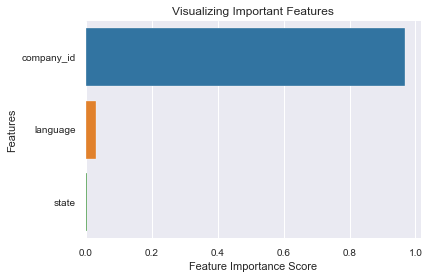

In [547]:
%matplotlib inline

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

So now we know that the user_id contains a lot of information. It would be useful to determine what those differences are so that we could pull from the other table. This could just be because user_id's increase with time.

<Figure size 1152x576 with 0 Axes>

Text(0.5, 1.0, 'User ID')

Text(0.5, 0, 'Creation Date')

Text(0, 0.5, 'User ID')

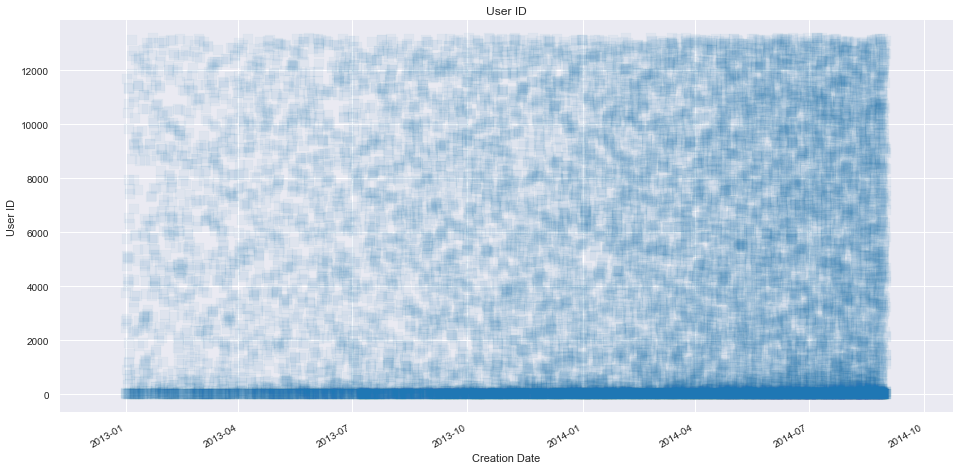

In [548]:
# Activation time vs time

plt.figure(figsize=(16,8))
plt.scatter(users['creation'],users['company_id'],s=100, marker='s', alpha=0.05)
plt.title('User ID')
plt.xlabel('Creation Date')
plt.ylabel('User ID')
plt.gcf().autofmt_xdate()
plt.show()

In [549]:
df.tail()

user_id  company_id  language  state  target
19061  19061.0      2156.0        10      1       1
19062  19062.0      7520.0         4      2       1
19063  19063.0        72.0         4      1       1
19064  19064.0         2.0         1      2       1
19065  19065.0      8352.0         9      2       1

## Data cleaning and preparation

Before we jump into EDA and modeling, let's take a closer look at the data.

### Missing Data

There are two columns that are incomplete. users.activated_at is missing ~50% of the data and events1.user_type is missing some data in the first 20% of the rows. Let's consider what these missing data are and their value.


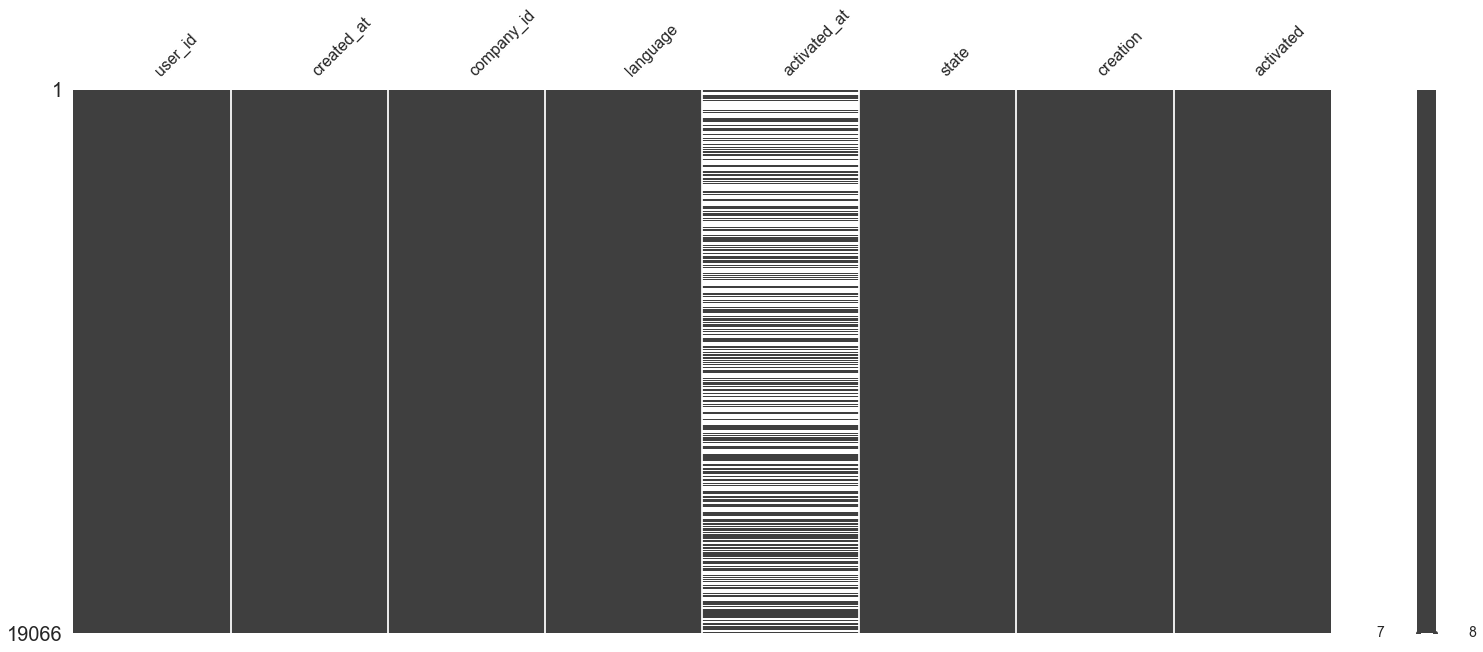

In [425]:
msno.matrix(users)

In [426]:
users.head()

user_id           created_at  company_id language         activated_at  \
0      0.0  2013-01-01 20:59:39      5737.0  english  2013-01-01 21:01:07   
1      1.0  2013-01-01 13:07:46        28.0  english                  NaN   
2      2.0  2013-01-01 10:59:05        51.0  english                  NaN   
3      3.0  2013-01-01 18:40:36      2800.0   german  2013-01-01 18:42:02   
4      4.0  2013-01-01 14:37:51      5110.0   indian  2013-01-01 14:39:05   

     state            creation  activated  
0   active 2013-01-01 20:59:39       True  
1  pending 2013-01-01 13:07:46      False  
2  pending 2013-01-01 10:59:05      False  
3   active 2013-01-01 18:40:36       True  
4   active 2013-01-01 14:37:51       True

So the activated_at is timing data. This is the time the user was activated, if they became active. Missing data here could mean two things, the user never activated, or the data are missing.. Therefore there is potential value in this information.

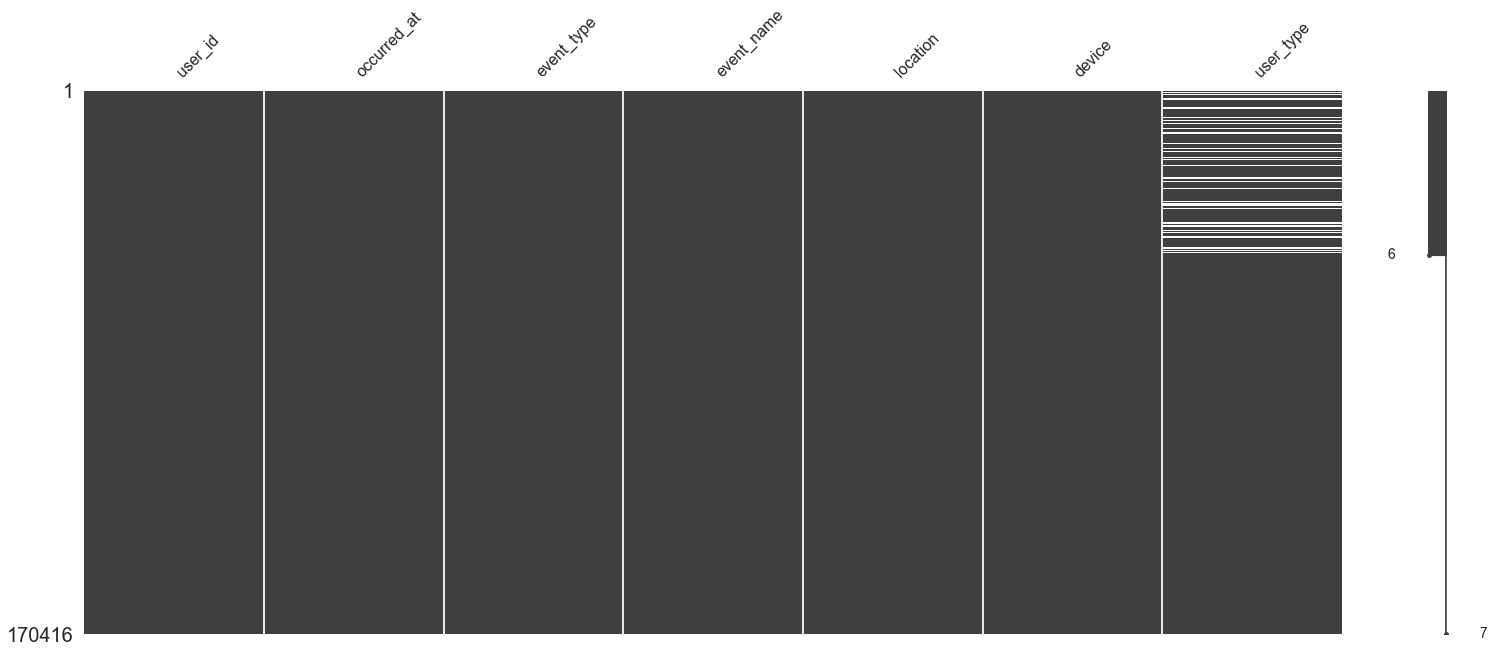

In [427]:
msno.matrix(events1)

In [428]:
events1.head()
events1['user_type'].unique()

user_id          occurred_at  event_type    event_name location  \
0  10522.0  2014-05-02 11:02:39  engagement         login    Japan   
1  10522.0  2014-05-02 11:02:53  engagement     home_page    Japan   
2  10522.0  2014-05-02 11:03:28  engagement  like_message    Japan   
3  10522.0  2014-05-02 11:04:09  engagement    view_inbox    Japan   
4  10522.0  2014-05-02 11:03:16  engagement    search_run    Japan   

                   device  user_type  
0  dell inspiron notebook        3.0  
1  dell inspiron notebook        3.0  
2  dell inspiron notebook        3.0  
3  dell inspiron notebook        3.0  
4  dell inspiron notebook        3.0

array([ 3.,  1.,  2., nan])

Unclear what this information is, only way to recover the missing data would be to look for correlation between this column and another..

### Pandas Profiling

In [482]:
pp.ProfileReport(users)

Lessons learned: A few important warnings. We should apply pd.to_datetime() to created_at column to get them into datetime format. activation_at is missing ~50% of the data, which could mean that user's never activated. 

Two interesting figures would be binned percent never activated vs time (ie normalized), and time to activation vs time.


In [483]:
pp.ProfileReport(events)

### Data Restructure

Let's create two new columns, one whether the user activated, and for those that did, how long it took.

In [535]:
# If the user activated, True else False
users['activated'] = True
users['activated'][users[users['activated_at'].isnull()].index] = False

# Time between creation and activation
users['activation_time'] = users['activated_at']
users['activation_time'][users[users['activated_at'].notnull()].index] = pd.to_datetime(users['activated_at'][users[users['activated_at'].notnull()].index]) - pd.to_datetime(users['created_at'][users[users['activated_at'].notnull()].index])

users['creation'] = pd.to_datetime(users['created_at'])


/Users/Austin/anaconda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Austin/anaconda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [536]:
events['occurrence'] = pd.to_datetime(events['occurred_at'])

## Joining tables / prep for modeling

### What is all this change?

There is obviously a change in the growth rate before and after the date. In order to identify what caused this, we will classify the users as before and after the change and determine the feature importance for the classification.

We will join the tables to bring in some of the information.

We want the final table to include:

- user_id
- created_at 
- company_id
- language 
- location
- device 
- user_type


One question is how much overlap is there between user ids in the two tables.

In [422]:
lst1 = users['user_id'].unique()
lst2 = events['user_id'].unique()

lst3 = intersection(lst1, lst2)

print('There are %i unique users from both tables' % len(lst3))

def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

There are 9760 unique users from both tables


In [440]:
# Create a new DataFrame with just these unique users.
df = users.copy()
events.head(2)

user_id          occurred_at  event_type event_name location  \
0  10522.0  2014-05-02 11:02:39  engagement      login    Japan   
1  10522.0  2014-05-02 11:02:53  engagement  home_page    Japan   

                   device  user_type          occurrence  
0  dell inspiron notebook        3.0 2014-05-02 11:02:39  
1  dell inspiron notebook        3.0 2014-05-02 11:02:53

In [441]:
df = pd.merge(users, events, on='user_id', how='inner')

In [461]:
df.head()
len(df)

user_id           created_at  company_id language         activated_at  \
0      4.0  2013-01-01 14:37:51      5110.0   indian  2013-01-01 14:39:05   
1      4.0  2013-01-01 14:37:51      5110.0   indian  2013-01-01 14:39:05   
2      4.0  2013-01-01 14:37:51      5110.0   indian  2013-01-01 14:39:05   
3      4.0  2013-01-01 14:37:51      5110.0   indian  2013-01-01 14:39:05   
4      4.0  2013-01-01 14:37:51      5110.0   indian  2013-01-01 14:39:05   

    state            creation  activated          occurred_at  event_type  \
0  active 2013-01-01 14:37:51       True  2014-05-13 09:31:47  engagement   
1  active 2013-01-01 14:37:51       True  2014-05-13 09:32:10  engagement   
2  active 2013-01-01 14:37:51       True  2014-05-13 09:32:26  engagement   
3  active 2013-01-01 14:37:51       True  2014-05-13 09:32:58  engagement   
4  active 2013-01-01 14:37:51       True  2014-05-24 11:39:53  engagement   

            event_name location             device  user_type  \
0                login    India    lenovo thinkpad        3.0   
1            home_page    India    lenovo thinkpad        3.0   
2  search_autocomplete    India    lenovo thinkpad        3.0   
3  search_autocomplete    India    lenovo thinkpad        3.0   
4                login    India  samsung galaxy s4        3.0   

           occurrence  
0 2014-05-13 09:31:47  
1 2014-05-13 09:32:10  
2 2014-05-13 09:32:26  
3 2014-05-13 09:32:58  
4 2014-05-24 11:39:53

340832

In [464]:

for f in lst3:
    df2 = df2.append(df[df['user_id'] == f].head(1))

In [466]:
df2 = df2.drop(columns=['activated_at','activated','occurred_at','event_name'])

In [476]:
df2 = df2.drop(columns=['creation'])

In [477]:
len(df2)

9761

In [479]:
df2['created_at'].max()

'2014-08-31 20:40:32'

In [552]:
events.head(20)

user_id          occurred_at  event_type    event_name     location  \
0   10522.0  2014-05-02 11:02:39  engagement         login        Japan   
1   10522.0  2014-05-02 11:02:53  engagement     home_page        Japan   
2   10522.0  2014-05-02 11:03:28  engagement  like_message        Japan   
3   10522.0  2014-05-02 11:04:09  engagement    view_inbox        Japan   
4   10522.0  2014-05-02 11:03:16  engagement    search_run        Japan   
5   10522.0  2014-05-02 11:03:43  engagement    search_run        Japan   
6   10612.0  2014-05-01 09:59:46  engagement         login  Netherlands   
7   10612.0  2014-05-01 10:00:18  engagement  like_message  Netherlands   
8   10612.0  2014-05-01 10:00:53  engagement  send_message  Netherlands   
9   10612.0  2014-05-01 10:01:24  engagement     home_page  Netherlands   
10  10612.0  2014-05-01 10:01:52  engagement  like_message  Netherlands   
11  10612.0  2014-05-01 10:02:17  engagement     home_page  Netherlands   
12  10612.0  2014-05-01 10:02:51  engagement    view_inbox  Netherlands   
13  10612.0  2014-05-01 10:03:17  engagement  like_message  Netherlands   
14  10612.0  2014-05-01 10:03:40  engagement     home_page  Netherlands   
15  10612.0  2014-05-01 10:04:06  engagement  send_message  Netherlands   
16  10612.0  2014-05-01 10:04:44  engagement  like_message  Netherlands   
17  10612.0  2014-05-01 10:05:18  engagement  send_message  Netherlands   
18  10736.0  2014-05-09 17:52:45  engagement         login      Austria   
19  10736.0  2014-05-09 17:53:16  engagement  like_message      Austria   

                    device  user_type          occurrence  
0   dell inspiron notebook        3.0 2014-05-02 11:02:39  
1   dell inspiron notebook        3.0 2014-05-02 11:02:53  
2   dell inspiron notebook        3.0 2014-05-02 11:03:28  
3   dell inspiron notebook        3.0 2014-05-02 11:04:09  
4   dell inspiron notebook        3.0 2014-05-02 11:03:16  
5   dell inspiron notebook        3.0 2014-05-02 11:03:43  
6                 iphone 5        1.0 2014-05-01 09:59:46  
7                 iphone 5        1.0 2014-05-01 10:00:18  
8                 iphone 5        1.0 2014-05-01 10:00:53  
9                 iphone 5        1.0 2014-05-01 10:01:24  
10                iphone 5        1.0 2014-05-01 10:01:52  
11                iphone 5        1.0 2014-05-01 10:02:17  
12                iphone 5        1.0 2014-05-01 10:02:51  
13                iphone 5        1.0 2014-05-01 10:03:17  
14                iphone 5        1.0 2014-05-01 10:03:40  
15                iphone 5        1.0 2014-05-01 10:04:06  
16                iphone 5        1.0 2014-05-01 10:04:44  
17                iphone 5        1.0 2014-05-01 10:05:18  
18               iphone 4s        2.0 2014-05-09 17:52:45  
19               iphone 4s        2.0 2014-05-09 17:53:16